In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from joblib import dump

from pathlib import Path
import numpy as np
import pandas as pd

def load_trimmed_sequences(data_dir, sequence_length=10):
    """
    Load pre-trimmed joint-coordinate CSVs and return:
      X: ndarray (n_samples, sequence_length, 39)
      y: ndarray (n_samples,) integer labels (1=Good, 0=Bad)
      filenames: list of str, the CSV filenames corresponding to each sample
    """
    data_dir = Path(data_dir)
    paths = sorted(data_dir.glob("[GW]*_trimmed.csv"))

    X_list, y_list, filenames = [], [], []
    for p in paths:
        stem = p.stem
        if stem.startswith("G"):
            label = 1
        elif stem.startswith("W"):
            label = 0
        else:
            continue  # ignore unexpected files

        # read and process sequence
        df = pd.read_csv(p)
        df = df.drop(columns=["FrameNo"], errors="ignore")
        seq = df.values
        F, D = seq.shape

        if F >= sequence_length:
            idx = np.linspace(0, F - 1, sequence_length, dtype=int)
            proc_seq = seq[idx]
        else:
            pad = np.zeros((sequence_length - F, D), dtype=seq.dtype)
            proc_seq = np.vstack([seq, pad])

        X_list.append(proc_seq)
        y_list.append(label)
        filenames.append(p.name)  # or use p.stem if you prefer no “.csv”

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=int)
    return X, y, filenames



def build_dense(n_hidden_layers=2, param_budget=10_000, input_shape=(10, 39)):
    """
    Build and compile a Sequential dense model targeting ~param_budget parameters.

    Returns a tf.keras.Model.
    """
    D = np.prod(input_shape)
    L = n_hidden_layers

    # solve for hidden units per layer
    if L == 1:
        h = int((param_budget - 1) / (D + 1))
    else:
        a, b, c = (L-1), (D+L+1), (1 - param_budget)
        disc = b*b - 4*a*c
        h = int((-b + np.sqrt(disc)) / (2*a))
    h = max(1, h)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        *[layers.Dense(h, activation="relu") for _ in range(L)],
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


def cross_validate_dense(
    X, y,
    n_hidden_layers,
    param_budget=10_000,
    n_splits=5,
    epochs=50,
    batch_size=32,
    patience=10,
    input_shape=(10,39),
    random_state=42
):
    """
    Stratified K-Fold CV for the dense model.

    Returns:
      fold_metrics: list of (loss, accuracy, precision, recall, f1, auc)
      histories:    list of history.history dicts
      y_trues:      list of true-label arrays per fold
      y_preds:      list of predicted-label arrays per fold
      y_probs:      list of predicted-prob arrays per fold
      y_idx:        flat list of all test-set indices, in fold order
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics, histories = [], []
    y_trues, y_preds, y_probs = [], [], []
    y_idx = []

    for train_i, test_i in skf.split(X, y):
        # collect indices
        y_idx.extend(test_i)

        # split and scale
        X_tr_raw, X_val_raw = X[train_i], X[test_i]
        y_tr, y_val         = y[train_i], y[test_i]
        flat_tr = X_tr_raw.reshape(-1, X.shape[-1])
        flat_val = X_val_raw.reshape(-1, X.shape[-1])
        scaler = StandardScaler().fit(flat_tr)
        X_tr = scaler.transform(flat_tr).reshape(X_tr_raw.shape)
        X_val = scaler.transform(flat_val).reshape(X_val_raw.shape)

        # build & fit
        model = build_dense(n_hidden_layers, param_budget, input_shape)
        es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size,
            verbose=0, callbacks=[es]
        )

        # predict & compute metrics
        y_prob = model.predict(X_val, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)

        loss, acc, prec, rec, auc_val = model.evaluate(X_val, y_val, verbose=0)
        fold_metrics.append((loss, acc, prec, rec, f1, auc_val))
        histories.append(history.history)

        y_trues.append(y_val)
        y_preds.append(y_pred)
        y_probs.append(y_prob)

    return fold_metrics, histories, y_trues, y_preds, y_probs, y_idx


def plot_average_loss(histories, ax=None, title_prefix="Average Loss"):
    """Plot mean train & val loss over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["loss"]) for h in histories)
    x = range(1, min_e+1)
    train = np.array([h["loss"][:min_e]     for h in histories]).mean(0)
    val   = np.array([h["val_loss"][:min_e] for h in histories]).mean(0)

    ax.plot(x, train, label="Train Loss")
    ax.plot(x, val,   label="Val Loss")
    ax.set(xlabel="Epoch", ylabel="Loss", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_average_precision_recall(histories, ax=None, title_prefix="Avg Precision & Recall"):
    """Plot mean train & val precision/recall over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["precision"]) for h in histories)
    x = range(1, min_e+1)
    tprec = np.array([h["precision"][:min_e]    for h in histories]).mean(0)
    vprec = np.array([h["val_precision"][:min_e] for h in histories]).mean(0)
    trec  = np.array([h["recall"][:min_e]       for h in histories]).mean(0)
    vrec  = np.array([h["val_recall"][:min_e]    for h in histories]).mean(0)

    ax.plot(x, tprec, label="Train Precision")
    ax.plot(x, vprec, label="Val Precision")
    ax.plot(x, trec,  label="Train Recall")
    ax.plot(x, vrec,  label="Val Recall")
    ax.set(xlabel="Epoch", ylabel="Metric", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_aggregated_roc(y_trues, y_probs, ax=None, title="ROC Curve"):
    """Plot one ROC/AUC over all folds combined."""
    if ax is None: ax = plt.gca()
    y_true_all = np.concatenate(y_trues)
    y_prob_all = np.concatenate(y_probs)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], "k--", label="Chance")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=title)
    ax.legend()


def plot_confusion_matrix(y_trues, y_preds, ax=None, labels=('Bad','Good'), title="Confusion Matrix"):
    """Plot aggregated confusion matrix over all folds."""
    if ax is None: ax = plt.gca()
    cms = [confusion_matrix(t, p) for t, p in zip(y_trues, y_preds)]
    total_cm = sum(cms)
    disp = ConfusionMatrixDisplay(total_cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)


def plot_cv_summary(histories, y_trues, y_preds, y_probs, depth, params):
    """
    2×2 summary: Loss, Precision/Recall, ROC & Confusion Matrix.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_average_loss(histories,                ax=axs[0,0])
    plot_average_precision_recall(histories,    ax=axs[0,1])
    plot_aggregated_roc(y_trues, y_probs,       ax=axs[1,0])
    plot_confusion_matrix(y_trues, y_preds,     ax=axs[1,1])
    fig.suptitle(f"{depth}-layer model (~{params} params)", fontsize=16)
    plt.tight_layout()
    plt.show()


def print_results(fold_metrics, metric_names=None):
    """
    Print mean of each metric across folds.
    fold_metrics tuples: (loss, accuracy, precision, recall, f1, auc)
    """
    if metric_names is None:
        metric_names = ["bce_loss","accuracy","precision","recall","f1_score","auc"]
    mean_vals = {
        name: np.mean([fm[i] for fm in fold_metrics])
        for i, name in enumerate(metric_names)
    }
    print("Mean CV metrics:")
    for name in metric_names:
        print(f"  {name.title():<9}: {mean_vals[name]:.4f}")


def get_misclassified(y_trues, y_preds, y_idx, filenames):
    """
    Given:
      y_trues:  list of 1D arrays of true labels (one array per fold)
      y_preds:  list of 1D arrays of predicted labels (same shape/order)
      y_idx:    flat list of original-sample indices (in fold order)
      filenames:list of str, filenames for each original sample

    Returns:
      mis_idx:   list of original indices where y_pred != y_true
      mis_files: list of filenames corresponding to those indices
    """
    # flatten all folds into one long vector
    flat_trues = np.concatenate(y_trues)
    flat_preds = np.concatenate(y_preds)

    # sanity checks
    n = len(y_idx)
    if len(flat_trues) != n or len(flat_preds) != n:
        raise ValueError("Length mismatch between y_idx and concatenated labels")
    if len(filenames) != n:
        raise ValueError("Length mismatch between filenames and samples")

    # collect misclassified indices
    mis_idx = [
        orig_i
        for orig_i, t, p in zip(y_idx, flat_trues, flat_preds)
        if t != p
    ]
    # map to filenames
    mis_files = [filenames[i] for i in mis_idx]

    return mis_idx, mis_files


X, y, filenames = load_trimmed_sequences("data/kinect_good_vs_bad_trimmed", sequence_length=10)

EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10

In [8]:
# Sweep over depths and compute mean CV accuracy
depths = range(1, 11)
mean_accuracies = []

for L in depths:
    fold_metrics, _, _, _, _, _ = cross_validate_dense(
        X, y,
        n_hidden_layers=L,
        param_budget=10_000,
        n_splits=5,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
    )
    # accuracy is at index 1
    accuracies = [m[1] for m in fold_metrics]
    mean_accuracies.append(np.mean(accuracies))

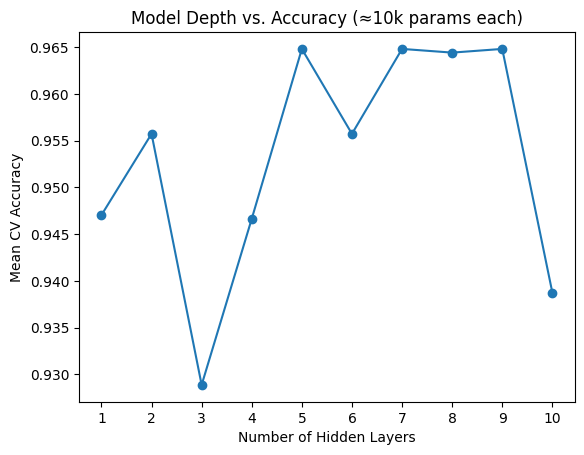

Best model depth: 5 hidden layers → mean CV accuracy = 0.9648


In [9]:
fig, ax = plt.subplots()
ax.plot(depths, mean_accuracies, '-o')
ax.set_xticks(depths)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Mean CV Accuracy")
ax.set_title("Model Depth vs. Accuracy (≈10k params each)")
plt.show()

# Find which depth gave the highest mean accuracy
best_idx = int(np.argmax(mean_accuracies))
best_depth = list(depths)[best_idx]
best_acc   = mean_accuracies[best_idx]

print(f"Best model depth: {best_depth} hidden layers → mean CV accuracy = {best_acc:.4f}")

In [10]:
LAYERS = best_depth
PARAMS = 10000

fold_metrics, histories, y_trues, y_preds, y_probs, y_idx = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

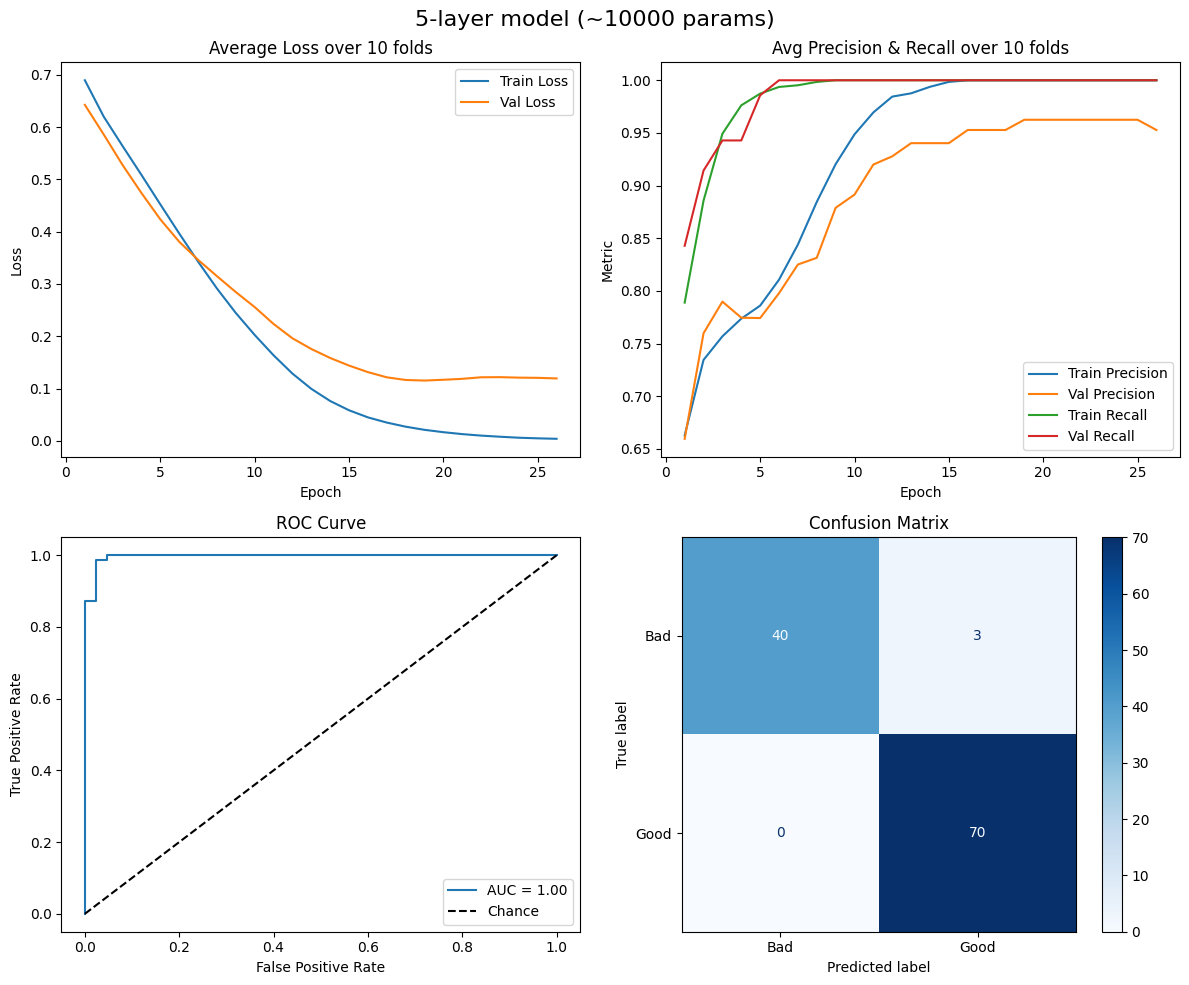

Mean CV metrics:
  Bce_Loss : 0.0947
  Accuracy : 0.9735
  Precision: 0.9625
  Recall   : 1.0000
  F1_Score : 0.9800
  Auc      : 0.9964

misclassified files:
--------------------
W24_trimmed.csv
W21_trimmed.csv
W08_trimmed.csv


In [11]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

_, mis_files = get_misclassified(y_trues, y_preds, y_idx, filenames)
print('\nmisclassified files:\n--------------------')
for f in mis_files:
    print(f)

In [12]:
# ——— Final training on full dataset ———

# 1) Fit scaler on all of X
flat_all   = X.reshape(-1, X.shape[-1])
final_scaler = StandardScaler()
flat_scaled = final_scaler.fit_transform(flat_all)
X_scaled    = flat_scaled.reshape(X.shape)

# 2) Build final model
depth = best_depth
final_model = build_dense(
    n_hidden_layers=depth,
    param_budget=10_000,
    input_shape=(10, 39)
)

# 3) Train on the full, scaled dataset
final_model.fit(
    X_scaled, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 4) Save both model and scaler
final_model.save(os.path.join("models", "kinect_dense_good_vs_bad_model.keras"))
dump(final_scaler, os.path.join("models", "kinect_dense_good_vs_bad_scaler.pkl"))
final_model.summary()
print("Model and scaler saved successfully!")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6217 - auc: 0.3757 - loss: 0.6906 - precision: 0.6259 - recall: 0.9861
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6507 - auc: 0.8558 - loss: 0.6392 - precision: 0.6455 - recall: 1.0000 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6480 - auc: 0.9586 - loss: 0.5974 - precision: 0.6373 - recall: 1.0000 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6919 - auc: 0.9789 - loss: 0.5434 - precision: 0.6745 - recall: 1.0000 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7182 - auc: 0.9817 - loss: 0.4981 - precision: 0.6813 - recall: 1.0000 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8448 - auc: 0.9905 - loss: 0.4117 - precision: 0.8073 - recall: 1.0000 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8759 - auc: 0.9933 - loss: 0.3706 - precision: 0.8285 - recall: 1.0000 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_121 (Flatten)           │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 20)             │         7,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_812 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,565 (111.59 KB)

 Trainable params: 9,521 (37.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,044 (74.39 KB)

Model and scaler saved successfully!
